### Description

#### Evaluates a number of estimators to construct the Voting Regressor meta-estimator with weights such that the mean squared error of the combined predictions of the estimators is minimized.

#### version: 2.0

#### TODO:


### Done:
- prune features
- full db integration
- finalize estimator selection
- estimator comp. df
- finalize 'fine tuning'
- save final estimators
- save final voting regressor
- plot results
- general file cleanup
- remove unused imports

In [118]:
# Import Dependencies
import pandas as pd
import numpy as np
import joblib

# Plots as needed
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.preprocessing import RobustScaler

# Data split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

# Model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ARDRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import HuberRegressor


# Model Validation and Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from scipy import stats

# MSE minimization
from sklearn.metrics import mean_squared_error
from scipy import optimize

# DB interface
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from config import db_password

## Interface with Database and create DataFrames

In [6]:
# Construct db string
user = 'postgres'
host = 'housing-prices.ch2ctomvepex.us-east-1.rds.amazonaws.com'
name = 'housing-prices'

db_string = f'postgresql://{user}:{db_password}@{host}/{name}'

In [7]:
# Create Connection Engine

engine = create_engine(db_string)

In [8]:
# map to Base to extract metadata
Base = automap_base()
Base.prepare(engine, reflect=True)

In [9]:
# List of tables corresponding to cities
table_names = []
city_list = ['austin','boston','sanfran','chandler','chicago','houston','la','pittsburgh','spokane']

# Group by city population
# To generalize, pop groups can be calc. based on population of known cities in groups.
low_list = ['chandler', 'pittsburgh', 'spokane']
mid_list = ['austin', 'boston', 'sf']
high_list = ['chicago', 'la', 'houston']

for k in Base.metadata.tables.keys():
    if k in city_list:
        table_names.append(k)

print(table_names)

['austin', 'sanfran', 'la', 'boston', 'chandler', 'pittsburgh', 'houston', 'spokane', 'chicago']


In [10]:
# Create df from comb. of all city tables

def city_df(eng,city_tables,lowpop_list=[],midpop_list=[],highpop_list=[]):
    
    all_pop = pd.DataFrame()
    
    for city in city_tables:
        
        if city in lowpop_list:
            
            # Create temp city df
            city = pd.read_sql_table(city, eng)
            
            # Add class col
            city['pop_class'] = 1
            
            # add to all_pop
            all_pop = pd.concat([all_pop,city])
            
        elif city in midpop_list:
            
            # Create temp city df
            city = pd.read_sql_table(city, eng)
            
            # Add class col
            city['pop_class'] = 2
            
            # add to all_pop
            all_pop = pd.concat([all_pop,city])
            
        elif city in highpop_list:
            
            # Create temp city df
            city = pd.read_sql_table(city, eng)
            
            # Add class col
            city['pop_class'] = 3
            
            # add to all_pop
            all_pop = pd.concat([all_pop,city])
               
    return all_pop

In [11]:
all_pop = city_df(eng=engine,city_tables=table_names,lowpop_list=low_list,
                  midpop_list=mid_list,highpop_list=high_list)
all_pop.head()

,price,bedroom,sqft,bathroom,amenity_count,cityid,pop_class
0,1191,1,600.0,1.0,5,1,2
1,1425,1,526.0,1.0,5,1,2
2,1266,1,578.0,1.0,5,1,2
3,1144,1,351.0,1.0,8,1,2
4,1775,4,1236.0,2.0,8,1,2


In [12]:
# Write to csv to prevent constant db calls
all_pop.to_csv('all_pop.csv',index=False)

In [119]:
# df from csv if needed
all_pop = pd.read_csv('all_pop.csv')

## Examine data

In [120]:
all_pop.describe()

,price,bedroom,sqft,bathroom,amenity_count,cityid,pop_class
count,4481.000000,4481.000000,4481.000000,4481.000000,4481.000000,4481.000000,4481.000000
mean,1842.516849,1.674403,939.883731,1.462174,5.571301,5.198393,1.950904
std,935.202674,0.942777,494.403762,0.633749,1.864343,2.632753,0.867467
min,225.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,1300.000000,1.000000,680.000000,1.000000,4.000000,3.000000,1.000000
50%,1653.000000,2.000000,875.000000,1.000000,6.000000,5.000000,2.000000
75%,2201.000000,2.000000,1114.000000,2.000000,7.000000,7.000000,3.000000
max,20000.000000,8.000000,15492.000000,5.000000,11.000000,9.000000,3.000000


In [121]:
# Check dtypes
all_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4481 entries, 0 to 4480
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4481 non-null   int64  
 1   bedroom        4481 non-null   int64  
 2   sqft           4481 non-null   float64
 3   bathroom       4481 non-null   float64
 4   amenity_count  4481 non-null   int64  
 5   cityid         4481 non-null   int64  
 6   pop_class      4481 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 245.2 KB


In [122]:
all_t = all_pop.copy()

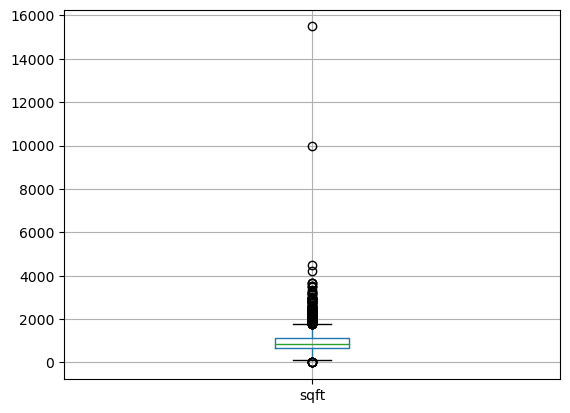

In [123]:
# Dist of num ft 'sqft' -> appears many outside 1.5*IQR
all_t.boxplot(column='sqft')
plt.show()

In [124]:
# Calc iqr of sqft and upper/lower bounds
sqft_iqr = all_t.sqft.quantile(.75)-all_t.sqft.quantile(.25)
upper = 1.5*sqft_iqr + all_t.sqft.quantile(.75)
lower =  all_t.sqft.quantile(.25) - 1.5*sqft_iqr
print(lower)
print(upper)

29.0
1765.0


In [125]:
all_t.drop(all_t[all_t.sqft > upper].index, inplace=True)

## Split Train and Test Data

In [126]:
# Before examination, split so that the test set remains unobserved

# Split using SSS to incorporate data from each of the 3 groups in test and train sets.
split = StratifiedShuffleSplit(n_splits=10,test_size=0.2, random_state=42)

for train_index, test_index in split.split(all_t, all_t['cityid']):
    strat_train_set = all_t.iloc[train_index]
    strat_test_set = all_t.iloc[test_index]

In [127]:
# Create a new df that is a copy of the training set to preserve it.
all_train = strat_train_set.copy()

# Repeat for test set
all_test = strat_test_set.copy()

# Show first 5 rows of training set
all_train.head()

,price,bedroom,sqft,bathroom,amenity_count,cityid,pop_class
3735,1458,2,875.0,1.0,7,9,1
1321,1725,2,822.0,2.0,6,3,3
1141,3070,1,680.0,1.0,7,3,3
3375,1695,4,1687.0,4.0,5,7,3
3631,1145,2,928.0,1.0,6,9,1


In [70]:
# Compare Train Test Split
train_set,test_set = train_test_split(all_t, test_size=0.2, random_state=42)

In [71]:
# df for comparison of test sets
split_comp = pd.DataFrame()
split_comp['Overall'] = all_t.cityid.value_counts() / len(all_t.cityid)
split_comp['Strat_City'] = all_test.cityid.value_counts() / len(all_test.cityid)
split_comp['Random'] = test_set.cityid.value_counts() / len(test_set.cityid)
split_comp['Random %Error'] = ((split_comp.Random - split_comp.Overall) / split_comp.Overall)*100
split_comp['Strat_City %Error'] = ((split_comp.Strat_City - split_comp.Overall) / split_comp.Overall)*100
split_comp

,Overall,Strat_City,Random,Random %Error,Strat_City %Error
5,0.162541,0.162194,0.163361,0.504299,-0.213589
3,0.154601,0.155193,0.166861,7.930425,0.382843
9,0.152032,0.151692,0.140023,-7.898628,-0.223514
1,0.149229,0.149358,0.162194,8.687546,0.086373
7,0.112331,0.112019,0.086348,-23.130778,-0.277766
8,0.096450,0.096849,0.091015,-5.635120,0.413911
4,0.091079,0.091015,0.107351,17.866140,-0.070012
6,0.081738,0.081680,0.082847,1.357560,-0.070012


#### Stratified Shuffle Split demonstrates better representation of the population groupings

In [128]:
# Drop columns not used in analysis
all_train.drop(columns=['cityid'],axis=1,inplace=True)
all_test.drop(columns=['cityid'],axis=1,inplace=True)

### Preprocess Finalized Feature Set

In [129]:
# Remove target

X_train = all_train.drop(columns='price').values
y_train = all_train.price.values

X_test = all_test.drop(columns='price').values
y_test = all_test.price.values

In [130]:
# Scale using RobustScaler due to spread

rs = RobustScaler()

robust = rs.fit(X_train)

X_train_scaled = robust.transform(X_train)

X_test_scaled = robust.transform(X_test)

## Estimator Construction

In [131]:
# Create fn to out scores from cross_val_score to select estimators

def score_info(scores):
    MSE = -scores
    confidence = 0.95
    con_int= stats.t.interval(
    confidence,
    len(MSE)-1,
    loc=MSE.mean(),
    scale=stats.sem(MSE))
    
    print(f'Mean: {MSE.mean()}')
    print(f'STD: {MSE.std()}')
    print(f'Conf. Interval: {con_int}')
    return [MSE.mean(), MSE.std(), con_int[0], con_int[1]]

In [132]:
# Gradient Boosting Regressor

gbr_cvs = cross_val_score(GradientBoostingRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

gbr_score = score_info(gbr_cvs)

Mean: 375769.54378802906
STD: 125185.79582916485
Conf. Interval: (304010.74797744385, 447528.33959861426)


In [133]:
# Random Forest Regressor

rfr_cvs = cross_val_score(RandomForestRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

rfr_score =score_info(rfr_cvs)

Mean: 327341.41506662476
STD: 124382.33344828656
Conf. Interval: (256043.1786393869, 398639.6514938626)


In [134]:
# Lasso

lasso_cvs = cross_val_score(LassoCV(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

lasso_score=score_info(lasso_cvs)

Mean: 459008.0778922629
STD: 135817.85092985368
Conf. Interval: (381154.79295881925, 536861.3628257066)


In [135]:
# Ridge

ridge_cvs = cross_val_score(RidgeCV(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ridge_score=score_info(ridge_cvs)

Mean: 459372.74060649436
STD: 135449.16597576332
Conf. Interval: (381730.79265552363, 537014.6885574651)


In [136]:
# Adaboost

ada_cvs = cross_val_score(AdaBoostRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ada_score=score_info(ada_cvs)

Mean: 452910.12779503467
STD: 135158.21024050328
Conf. Interval: (375434.96101167286, 530385.2945783965)


In [137]:
#ARDRegression

ard_cvs = cross_val_score(ARDRegression(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ard_score=score_info(ard_cvs)

Mean: 458700.2559150482
STD: 135575.93340368196
Conf. Interval: (380985.6425477241, 536414.8692823723)


In [138]:
# SVM with polynomial kernel

svp_cvs = cross_val_score(SVR(kernel='poly'),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svp_score = score_info(svp_cvs)

Mean: 597879.5504797599
STD: 164470.75239257366
Conf. Interval: (503601.89653683215, 692157.2044226876)


In [139]:
svl_cvs = cross_val_score(SVR(kernel='linear'),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svl_score = score_info(svl_cvs)

Mean: 524676.0645014547
STD: 145736.50093396587
Conf. Interval: (441137.2273402404, 608214.901662669)


In [140]:
svr_cvs = cross_val_score(SVR(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svr_score = score_info(svr_cvs)

Mean: 611272.5115581024
STD: 157090.11523039758
Conf. Interval: (521225.5742996407, 701319.4488165642)


In [141]:
svs_cvs = cross_val_score(SVR(kernel='sigmoid'),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svs_score = score_info(svs_cvs)

Mean: 584268.2301776285
STD: 152337.9653734048
Conf. Interval: (496945.31243744027, 671591.1479178166)


In [142]:
# K nearest regression

knn_cvs = cross_val_score(KNeighborsRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

knn_score = score_info(knn_cvs)

Mean: 394820.6296240967
STD: 141117.04288712866
Conf. Interval: (313929.7506001692, 475711.5086480242)


In [143]:
bag_cvs = cross_val_score(BaggingRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

bag_score= score_info(bag_cvs)

Mean: 344977.9093850372
STD: 119315.95671784497
Conf. Interval: (276583.81308720657, 413372.00568286784)


In [144]:
hbr_cvs = cross_val_score(HuberRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

huber_score = score_info(hbr_cvs)

Mean: 465092.1729987663
STD: 136563.8052353258
Conf. Interval: (386811.29336629267, 543373.0526312399)


In [145]:
mod_type = ['Tree','Tree','Lin','Lin','Tree','Lin','Poly','Lin',
                       'RBF','Logistic','Cluster','Tree','Lin']
est_pre = pd.DataFrame([gbr_score,rfr_score,lasso_score,ridge_score,
                       ada_score,ard_score,svp_score,svl_score,
                        svr_score,svs_score,knn_score,bag_score,huber_score],
                       columns=['Mean MSE','Stdev MSE','CI Low','CI High'],
                       index=['GBR','RFR','Lasso','Ridge','AdaB','ARD','SVR(Poly)',
                              'SVR(rbf)','SVR(linear)','SVR(sigmoid)','Knearest',
                             'Bagging(tree)','Huber'])
est_pre['Model_Type'] = mod_type

In [46]:
est_pre.sort_values(by=['Mean MSE','Stdev MSE'])

,Mean MSE,Stdev MSE,CI Low,CI High,Model_Type
RFR,326005.263886,72901.130050,284216.998125,367793.529647,Tree
Bagging(tree),344931.802745,79618.698221,299292.903615,390570.701875,Tree
GBR,355769.360001,52978.999002,325400.825404,386137.894597,Tree
Knearest,373307.631419,68298.931653,334157.430247,412457.832591,Cluster
ARD,445986.230549,70177.433606,405759.237580,486213.223518,Lin
Lasso,446691.076829,69964.754770,406585.995273,486796.158386,Lin
Ridge,447200.476119,70046.352475,407048.621260,487352.330978,Lin
Huber,453606.952198,73403.135812,411530.927521,495682.976876,Lin
AdaB,507996.308963,72769.345784,466283.584362,549709.033564,Tree
SVR(rbf),523632.538341,76202.801618,479951.693839,567313.382843,Lin


#### Best 8 Models by MSE
- RFR (Tree)
- Bagging (Tree)
- GBR (Tree)
- Knearest (cluster)
- ARD (lin)
- Lasso (lin)
- Ridge (lin)
- Huber (lin)

#### Not significant variation in model type as desired

## Estimator Tuning

In [146]:
def mod_imp(model):
    scores = cross_val_score(model,X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)
    
    MSE = -scores
    confidence = 0.95
    con_int= stats.t.interval(
    confidence,
    len(MSE)-1,
    loc=MSE.mean(),
    scale=stats.sem(MSE))
    
    print(f'Mean: {MSE.mean()}')
    print(f'STD: {MSE.std()}')
    print(f'Conf. Interval: {con_int}')
    return [MSE.mean(), MSE.std(), con_int[0], con_int[1]]

In [147]:
# GBR

model = GradientBoostingRegressor()


mod_params = {
    'learning_rate': np.arange(.25,.35,.01),
    'n_estimators': np.arange(8,14),
    'subsample': np.arange(.93,.97,.005),
    'max_depth': np.arange(7,12),
    'random_state': [42],
    'max_features': ['sqrt'],
    'alpha': [1e-30]
}


    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
gbr = model_cv.best_estimator_

gbr_imp = mod_imp(gbr)

Fitting 15 folds for each of 2400 candidates, totalling 36000 fits
Mean: 323050.4373317312
STD: 129102.695047085
Conf. Interval: (249046.40299925377, 397054.4716642086)


In [56]:
# Save Tuned Model
joblib.dump(gbr,'mod_params/gbr.pkl')

['mod_params/gbr.pkl']

In [148]:
# RFR

model = RandomForestRegressor()


mod_params = {
    'n_estimators': np.arange(20,40),
    'random_state': [42],
    'max_features': ['sqrt']
}

    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
rfr = model_cv.best_estimator_

rfr_imp = mod_imp(rfr)

Fitting 15 folds for each of 20 candidates, totalling 300 fits
Mean: 321591.1757126402
STD: 129681.56619692956
Conf. Interval: (247255.3218125577, 395927.02961272275)


In [60]:
joblib.dump(rfr,'mod_params/rfr.pkl')

['mod_params/rfr.pkl']

In [149]:
# Bagging

model = BaggingRegressor(random_state=42,n_jobs=-1)


mod_params = {
    'n_estimators': np.arange(1,50)
}

    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
bag = model_cv.best_estimator_

bag_imp = mod_imp(bag)

Fitting 15 folds for each of 49 candidates, totalling 735 fits
Mean: 327956.8830793768
STD: 124394.34015688118
Conf. Interval: (256651.76418640325, 399262.0019723504)


In [63]:
joblib.dump(bag,'mod_params/bag.pkl')

['mod_params/bag.pkl']

In [150]:
# ARD

model = ARDRegression(n_iter=1000)


mod_params = {
    'alpha_1': [1e-50,1e-25],
    'alpha_2': [1e-50],
    'lambda_1': [1e-50],
    'lambda_2': [1e-50]
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
ard = model_cv.best_estimator_

ard_imp = mod_imp(ard)

Fitting 15 folds for each of 2 candidates, totalling 30 fits
Mean: 458700.23196134076
STD: 135575.93661065368
Conf. Interval: (380985.6167557216, 536414.8471669599)


In [91]:
joblib.dump(ard,'mod_params/ard.pkl')

['mod_params/ard.pkl']

In [151]:
lasso = LassoCV(n_alphas=1000,max_iter=5000, cv=15,n_jobs=-1,
               random_state=42)
lasso_imp = mod_imp(lasso)

Mean: 459083.15853745904
STD: 135743.54517091202
Conf. Interval: (381272.46702883753, 536893.8500460805)


In [95]:
joblib.dump(lasso,'mod_params/lasso.pkl')

['mod_params/lasso.pkl']

In [152]:
ridge = RidgeCV(alphas=[1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2],cv=15)
ridge_imp = mod_imp(ridge)

Mean: 459201.23091414286
STD: 135604.9043925962
Conf. Interval: (381470.010844244, 536932.4509840417)


In [97]:
joblib.dump(ridge,'mod_params/ridge.pkl')

['mod_params/ridge.pkl']

In [153]:
# KNN

model = KNeighborsRegressor(n_jobs=-1)


mod_params = {
    'n_neighbors': np.arange(10,40,1),
    'weights': ['distance'],
    'p': [1]
    
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
knn = model_cv.best_estimator_

knn_imp = mod_imp(knn)

Fitting 15 folds for each of 30 candidates, totalling 450 fits
Mean: 325931.5689213379
STD: 139751.9397358711
Conf. Interval: (245823.19207860954, 406039.94576406624)


In [102]:
joblib.dump(knn,'mod_params/knn.pkl')

['mod_params/knn.pkl']

In [154]:
# Huber

model = HuberRegressor(max_iter=1000)


mod_params = {
    'epsilon': np.arange(10.5,11.5,.001),
    'alpha': [.01]
    
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
huber = model_cv.best_estimator_

huber_imp = mod_imp(huber)

Fitting 15 folds for each of 1000 candidates, totalling 15000 fits
Mean: 459197.7340513194
STD: 135577.7047414754
Conf. Interval: (381482.10532066127, 536913.3627819775)


In [111]:
joblib.dump(huber,'mod_params/huber.pkl')

['mod_params/huber.pkl']

In [155]:
est_post = pd.DataFrame([gbr_imp,rfr_imp,bag_imp,ard_imp,lasso_imp,ridge_imp,
                       knn_imp,huber_imp],
                       columns=['Mean MSE','Stdev MSE','CI Low','CI High'],
                       index=['GBR','RFR','Bagging(tree)','ARD','Lasso','Ridge',
                              'Knearest','Huber'])
est_post

,Mean MSE,Stdev MSE,CI Low,CI High
GBR,323050.437332,129102.695047,249046.402999,397054.471664
RFR,321591.175713,129681.566197,247255.321813,395927.029613
Bagging(tree),327956.883079,124394.340157,256651.764186,399262.001972
ARD,458700.231961,135575.936611,380985.616756,536414.847167
Lasso,459083.158537,135743.545171,381272.467029,536893.850046
Ridge,459201.230914,135604.904393,381470.010844,536932.450984
Knearest,325931.568921,139751.939736,245823.192079,406039.945764
Huber,459197.734051,135577.704741,381482.105321,536913.362782


In [34]:
# Load Models if needed
# gbr = joblib.load('mod_params/gbr.pkl')
# rfr = joblib.load('mod_params/rfr.pkl')
# bag = joblib.load('mod_params/bag.pkl')
# ard = joblib.load('mod_params/ard.pkl')
# lasso = joblib.load('mod_params/lasso.pkl')
# ridge = joblib.load('mod_params/ridge.pkl')
# knn = joblib.load('mod_params/knn.pkl')
# huber = joblib.load('mod_params/huber.pkl')

In [156]:
# Fit Estimators
gbr.fit(X_train_scaled,y_train)
rfr.fit(X_train_scaled,y_train)
bag.fit(X_train_scaled,y_train)
ard.fit(X_train_scaled,y_train)
lasso.fit(X_train_scaled,y_train)
ridge.fit(X_train_scaled,y_train)
knn.fit(X_train_scaled,y_train)
huber.fit(X_train_scaled,y_train)

HuberRegressor(alpha=0.01, epsilon=11.497999999999447, max_iter=1000)

## Weighted VotingRegressor

### Minimize MSE of models

In [157]:
# Specify number of estimators
n_est = 8

# Create a 'weights' array with default values of 1/n_est
w = (1/n_est)*np.ones(n_est)

In [158]:
# Create vector of predicted values from each estimator
gbr_pred = gbr.predict(X_test_scaled)
rfr_pred = rfr.predict(X_test_scaled)
bag_pred= bag.predict(X_test_scaled)
ard_pred = ard.predict(X_test_scaled)
lasso_pred = lasso.predict(X_test_scaled)
ridge_pred = ridge.predict(X_test_scaled)
knn_pred = knn.predict(X_test_scaled)
huber_pred = huber.predict(X_test_scaled)

In [159]:
# Combine prediction vectors into prediction matrix
mod_pred = np.column_stack((gbr_pred,rfr_pred,bag_pred,ard_pred,lasso_pred,ridge_pred,
                            knn_pred,huber_pred))

In [160]:
# Define Objective Function
def obj_fun(weights=w,y_true=y_test,y_hat=mod_pred, n_estimators=n_est):
    return (1/n_est)*np.sum((y_true - (weights@(y_hat.T)))**2)

In [161]:
# Define constraint(s)
def constraints(weights=w):
    return (1- np.sum(np.abs(weights)))

In [162]:
res = optimize.minimize(obj_fun, (1/n_est)*np.ones(n_est), method='SLSQP',
                  constraints={'fun': constraints,
                              'type': 'eq'}, options={'maxiter': 1000})
res

     fun: 29890242.539262038
     jac: array([-13788671.  , -13725253.25, -13705091.25, -10966596.  ,
       -10948698.  , -10911154.75, -14116413.75, -10904079.  ])
 message: 'Optimization terminated successfully'
    nfev: 620
     nit: 44
    njev: 44
  status: 0
 success: True
       x: array([2.95982502e-01, 1.07835807e-01, 6.95790647e-02, 5.52349488e-02,
       4.16686476e-02, 2.49077750e-05, 4.29670751e-01, 3.37115503e-06])

In [163]:
optimal_mod_weights = res.x

In [164]:
# Scale weights

# First argsort returns array with first value is the index of the smallest value
# in the array provided
scaled_weights = np.argsort(optimal_mod_weights)

# Second sort returns array firs value the index of the smallest value of input
# Such that the largest value in optimal_mod_weights will have the largest index
# The resulting array has sorted and scaled from len(array) to 0

scaled_weights = np.argsort(scaled_weights)

# Add 1 to prevent zero weights
scaled_weights = scaled_weights + 1
scaled_weights

array([7, 6, 5, 4, 3, 2, 8, 1], dtype=int64)

### Create VotingRegressor with new weights

In [169]:
estimators = [('gbr',gbr),('rfr',rfr),('bag',bag),('ard',ard),('lasso',lasso),('ridge',ridge),
            ('knn',knn),('huber',huber)]


vrg = VotingRegressor(estimators,
                     weights=scaled_weights,
                     n_jobs=-1)

vrg.fit(X_train_scaled, y_train)

VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(alpha=1e-30,
                                                       learning_rate=0.32000000000000006,
                                                       max_depth=11,
                                                       max_features='sqrt',
                                                       n_estimators=10,
                                                       random_state=42,
                                                       subsample=0.9450000000000001)),
                            ('rfr',
                             RandomForestRegressor(max_features='sqrt',
                                                   n_estimators=37,
                                                   random_state=42)),
                            ('bag',
                             BaggingRegressor(n_estimators=36, n_jobs=-1,
                                              random_state=4...
                             LassoCV(cv=15, max_iter=5000, n_alphas=1000,
                                     n_jobs=-1, random_state=42)),
                            ('ridge',
                             RidgeCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                             10.0, 100.0],
                                     cv=15)),
                            ('knn',
                             KNeighborsRegressor(n_jobs=-1, n_neighbors=26, p=1,
                                                 weights='distance')),
                            ('huber',
                             HuberRegressor(alpha=0.01,
                                            epsilon=11.497999999999447,
                                            max_iter=1000))],
                n_jobs=-1,
                weights=array([7, 6, 5, 4, 3, 2, 8, 1], dtype=int64))

In [168]:
# Compute cv score for comparison
vrg_cvs = cross_val_score(vrg,X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

vrg_score = score_info(vrg_cvs)

Mean: 320026.7348927679
STD: 129592.34398011945
Conf. Interval: (245742.02480493212, 394311.4449806037)


In [148]:
joblib.dump(vrg,'mod_params/vrg.pkl')

['mod_params/vrg.pkl']

In [167]:
# Load vrg
vrg = joblib.load('mod_params/vrg.pkl')
vrg.fit(X_train_scaled, y_train)

VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(alpha=1e-30,
                                                       learning_rate=0.26,
                                                       max_depth=11,
                                                       max_features='sqrt',
                                                       n_estimators=9,
                                                       random_state=42,
                                                       subsample=0.9400000000000001)),
                            ('rfr',
                             RandomForestRegressor(max_features='sqrt',
                                                   n_estimators=34,
                                                   random_state=42)),
                            ('bag',
                             BaggingRegressor(n_estimators=49, n_jobs=-1,
                                              random_state=42)),
                            ('ard',
                             ARDRe...
                             LassoCV(cv=15, max_iter=5000, n_alphas=1000,
                                     n_jobs=-1, random_state=42)),
                            ('ridge',
                             RidgeCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                             10.0, 100.0],
                                     cv=15)),
                            ('knn',
                             KNeighborsRegressor(n_jobs=-1, n_neighbors=30, p=1,
                                                 weights='distance')),
                            ('huber',
                             HuberRegressor(alpha=0.01,
                                            epsilon=10.891999999999783,
                                            max_iter=1000))],
                n_jobs=-1,
                weights=array([5, 7, 3, 6, 2, 1, 8, 4], dtype=int64))

In [170]:
# Display Score on train vs. test
print(f'Training Score: {vrg.score(X_train_scaled, y_train)}')
print(f'Testing Score: {vrg.score(X_test_scaled, y_test)}')

Training Score: 0.8366256204825293
Testing Score: 0.5677792009691872


## Plots

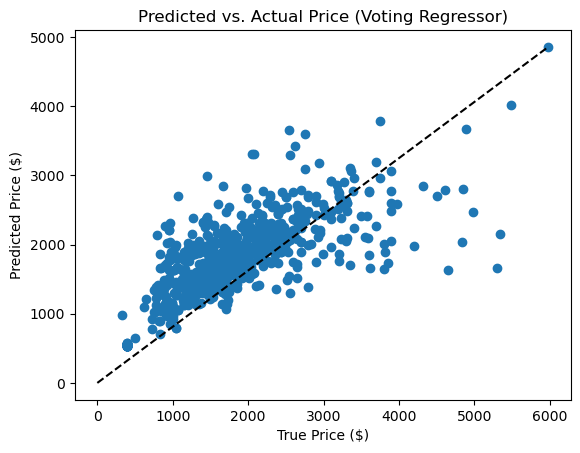

In [172]:
plt.figure()
plt.scatter(y_test,vrg.predict(X_test_scaled))
plt.plot([0,np.max(y_test)],[0,np.max(vrg.predict(X_test_scaled))],'--k')
plt.axis('tight')
plt.xlabel('True Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Predicted vs. Actual Price (Voting Regressor)')
#plt.savefig('figs/pred_vs_actual_vrg.png')

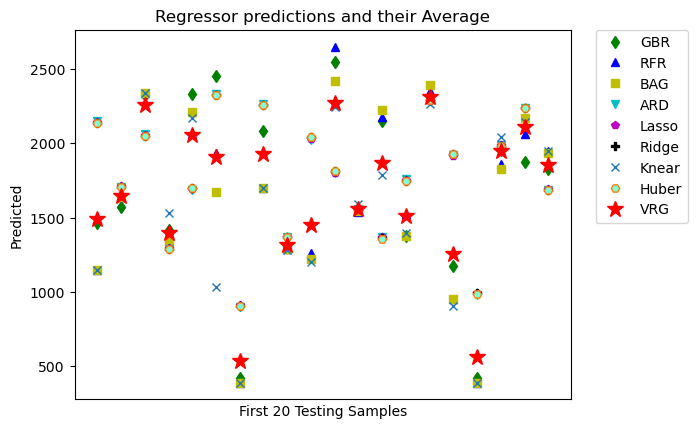

In [173]:
plt.figure()
plt.plot(gbr_pred[:20],'gd',label='GBR')
plt.plot(rfr_pred[:20],'b^',label='RFR')
plt.plot(bag_pred[:20],'ys',label='BAG')
plt.plot(ard_pred[:20],'cv',label='ARD')
plt.plot(lasso_pred[:20],'pm',label='Lasso')
plt.plot(ridge_pred[:20],'Pk',label='Ridge')
plt.plot(knn_pred[:20],'x',label='Knear')
plt.plot(huber_pred[:20],'H',markerfacecolor='aquamarine',label='Huber')
plt.plot(vrg.predict(X_test_scaled)[:20],'r*',label='VRG', markersize=12)

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("Predicted")
plt.xlabel("First 20 Testing Samples")
plt.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0)
plt.title("Regressor predictions and their Average")
#plt.savefig('figs/pred_vs_avg.png')